In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from math import sin
from math import pi
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from numpy import concatenate
from math import sqrt

In [52]:
warnings.simplefilter('ignore')

In [53]:
data = pd.read_csv('products.csv', sep='|', error_bad_lines=False)

In [54]:
data.head()

,WEEK,PLN,PLN_LABEL,PRODUCT_CATEGORY,PRODUCT_CATEGORY_LABEL,OPSTUDY,OPSTUDY_LABEL,ACTUAL,BU,SEG,PROMO
0,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,2,Consumables,B,N
1,1160529,40000223091,NIDO MILK PWDR NIDO FCRM 28.16OZ,006-108,ETHNIC,6,GENERAL GROCERIES,36,Consumables,C4,N
2,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1198,Health/Wellness,A,Y
3,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,9,Health/Wellness,A,N
4,1160529,40000755059,FUNGICURE ANTIFUNGL LIQ 1OZ,047-001,ANTI-FUNGAL,47,FOOT NEEDS,1479,Health/Wellness,C1,Y


In [55]:
def replace_negative(x):
    if x<0:
        return 0
    else:
        return x

In [56]:
def date_divide(x):
    x=x[1:]
    x='20' + x
    x=x[:4] + '-' + x[4:]
    x=x[:7] + '-' + x[7:]
    return x

In [57]:
aggregation = {
    'ACTUAL': 'sum',
    'PROMO': 'max',
    'YEAR': 'max',
    'MONTH': 'max',
    'DAY': 'max'
}

In [58]:
def sin_day(val):
    return sin(val*(2*pi)/31)

In [104]:
def sin_month(val):
    return sin(val*(2*pi)/12)

In [105]:
opst_51 = data[data['OPSTUDY']==51].copy()

In [106]:
opst_51.drop(['PLN_LABEL', 'PRODUCT_CATEGORY', 'PRODUCT_CATEGORY_LABEL', 'OPSTUDY', 'OPSTUDY_LABEL', 'BU', 'SEG'], axis=1, inplace=True)

In [107]:
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: str(x))
opst_51['PLN'] = opst_51['PLN'].apply(lambda x: str(x))
opst_51['ACTUAL'] = opst_51['ACTUAL'].apply(lambda x: float(x))
opst_51['PROMO'] = opst_51['PROMO'].apply(lambda x: str(x))
opst_51['WEEK'] = opst_51['WEEK'].apply(lambda x: date_divide(x))

In [108]:
opst_51['WEEK'] = pd.to_datetime(opst_51['WEEK'])
opst_51['YEAR'] = [d.year for d in opst_51['WEEK']]
opst_51['MONTH'] = [d.month for d in opst_51['WEEK']]
opst_51['DAY'] = [d.day for d in opst_51['WEEK']]

In [109]:
promo_dict = {'N':0, 'Y':1}
opst_51['PROMO'] = opst_51['PROMO'].replace(promo_dict)
opst_51['PROMO'] = opst_51['PROMO'].replace({'nan':0})

In [125]:
opst_51 = opst_51.groupby(['WEEK', 'PLN'], as_index=False).agg(aggregation)

In [126]:
first_pln = opst_51[opst_51['PLN']=='40000131497'].copy()

In [127]:
first_pln.drop('PLN', axis=1, inplace=True)

In [128]:
first_pln['YEAR_MONTH'] = [str(d.year) + '/' + str(d.month) for d in first_pln['WEEK']]
year_month = np.unique(first_pln['YEAR_MONTH'].values)
ym_mean = np.array([first_pln[first_pln['YEAR_MONTH']==d]['ACTUAL'].mean() for d in year_month])
mean_dict = dict(zip(year_month, ym_mean))
first_pln['MEAN_PER_MONTH'] = first_pln['YEAR_MONTH'].replace(mean_dict)

In [129]:
scaler = MinMaxScaler()
scaler.fit(np.array(first_pln['ACTUAL']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['ACTUAL']).reshape(-1, 1))
first_pln['ACTUAL'] = norm_act.ravel()

In [130]:
scaler.fit(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
norm_act = scaler.transform(np.array(first_pln['MEAN_PER_MONTH']).reshape(-1, 1))
first_pln['MEAN_PER_MONTH'] = norm_act.ravel()

In [131]:
first_pln.reset_index(inplace=True)
first_pln.set_index('WEEK', inplace=True)
first_pln.drop(['YEAR_MONTH', 'YEAR'], axis=1, inplace=True)
first_pln['MONTH'] = first_pln['MONTH'].apply(lambda m: sin_month(m))
first_pln['DAY'] = first_pln['DAY'].apply(lambda d: sin_day(d))
first_pln.reset_index('WEEK', inplace=True)
first_pln.drop('index', axis=1, inplace=True)

In [132]:
first_pln.head()

,WEEK,ACTUAL,PROMO,MONTH,DAY,MEAN_PER_MONTH
0,2015-02-08,0.046961,0,0.866025,0.998717,0.037634
1,2015-02-15,0.039595,0,0.866025,0.101168,0.037634
2,2015-02-22,0.039595,0,0.866025,-0.968077,0.037634
3,2015-03-01,0.033149,0,1.000000,0.201299,0.083073
4,2015-03-08,0.067219,0,1.000000,0.998717,0.083073


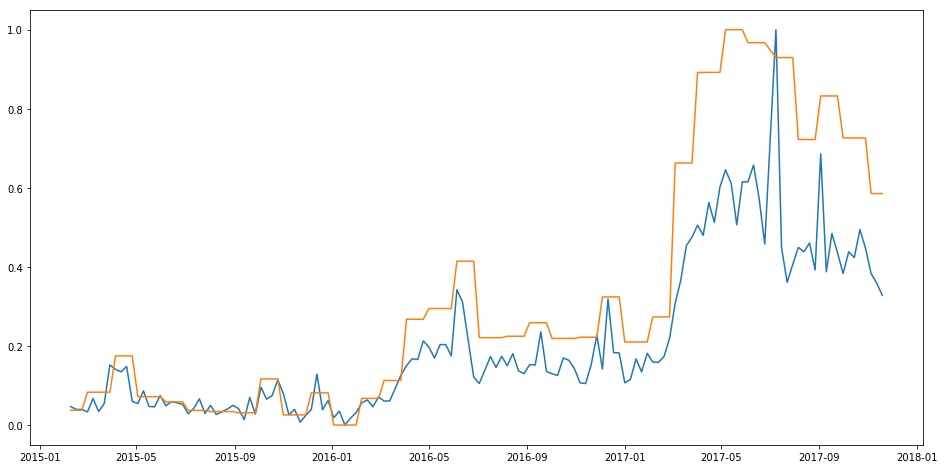

In [133]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['ACTUAL'])
plt.plot(first_pln['WEEK'], first_pln['MEAN_PER_MONTH'])
plt.show()

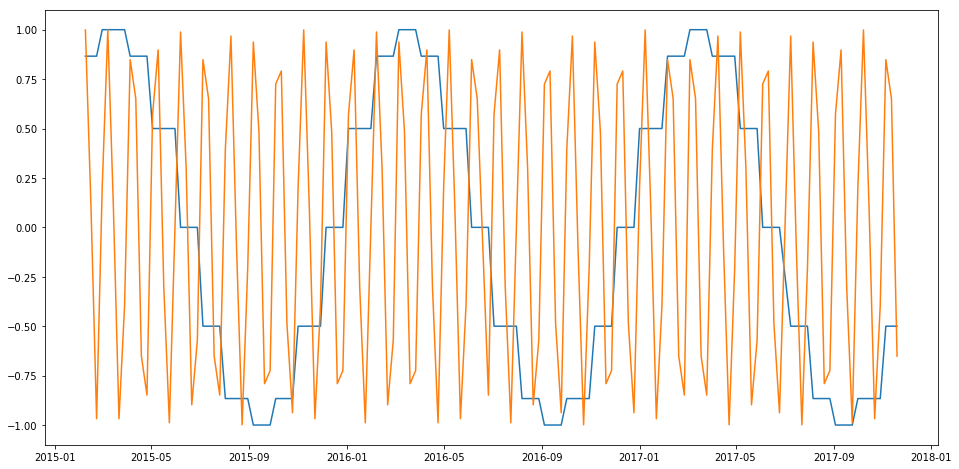

In [134]:
plt.figure(figsize=(16,8))
plt.plot(first_pln['WEEK'], first_pln['MONTH'])
plt.plot(first_pln['WEEK'], first_pln['DAY'])
plt.show()

In [135]:
act = first_pln['ACTUAL']
first_pln.drop('ACTUAL', axis=1, inplace = True)
first_pln.insert(5, 'ACTUAL', act)

In [140]:
first_pln['WEEK'] = first_pln['WEEK'].apply(lambda x: str(x))

In [146]:
first_pln.set_index('WEEK', inplace=True)

In [162]:
first_pln.head()

,PROMO,MONTH,DAY,MEAN_PER_MONTH,ACTUAL
WEEK,,,,,
2015-02-08 00:00:00,0,0.866025,0.998717,0.037634,0.046961
2015-02-15 00:00:00,0,0.866025,0.101168,0.037634,0.039595
2015-02-22 00:00:00,0,0.866025,-0.968077,0.037634,0.039595
2015-03-01 00:00:00,0,1.000000,0.201299,0.083073,0.033149
2015-03-08 00:00:00,0,1.000000,0.998717,0.083073,0.067219


In [163]:
lstm_data = first_pln.values

In [164]:
train = lstm_data[:100, :]
test = lstm_data[100:, :]
X_train, y_train = train[:, :-1], train[:, -1]
X_test, y_test = test[:, :-1], test[:, -1]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(100, 1, 4) (100,) (44, 1, 4) (44,)


In [165]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=50, batch_size=72, validation_data=(X_test, y_test), verbose=2, shuffle=False)

Train on 100 samples, validate on 44 samples
Epoch 1/50
 - 1s - loss: 0.1137 - val_loss: 0.4526
Epoch 2/50
 - 0s - loss: 0.1048 - val_loss: 0.4414
Epoch 3/50
 - 0s - loss: 0.0965 - val_loss: 0.4298
Epoch 4/50
 - 0s - loss: 0.0882 - val_loss: 0.4181
Epoch 5/50
 - 0s - loss: 0.0802 - val_loss: 0.4064
Epoch 6/50
 - 0s - loss: 0.0726 - val_loss: 0.3948
Epoch 7/50
 - 0s - loss: 0.0663 - val_loss: 0.3834
Epoch 8/50
 - 0s - loss: 0.0610 - val_loss: 0.3722
Epoch 9/50
 - 0s - loss: 0.0568 - val_loss: 0.3613
Epoch 10/50
 - 0s - loss: 0.0541 - val_loss: 0.3509
Epoch 11/50
 - 0s - loss: 0.0526 - val_loss: 0.3411
Epoch 12/50
 - 0s - loss: 0.0515 - val_loss: 0.3317
Epoch 13/50
 - 0s - loss: 0.0506 - val_loss: 0.3227
Epoch 14/50
 - 0s - loss: 0.0502 - val_loss: 0.3143
Epoch 15/50
 - 0s - loss: 0.0503 - val_loss: 0.3065
Epoch 16/50
 - 0s - loss: 0.0505 - val_loss: 0.2993
Epoch 17/50
 - 0s - loss: 0.0507 - val_loss: 0.2926
Epoch 18/50
 - 0s - loss: 0.0509 - val_loss: 0.2864
Epoch 19/50
 - 0s - loss: 0.

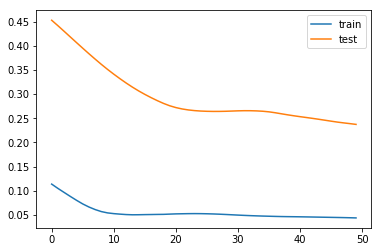

In [166]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [167]:
yhat = model.predict(X_test)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
inv_yhat = concatenate((yhat, X_test[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
y_test = y_test.reshape((len(y_test), 1))
inv_y = concatenate((y_test, X_test[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 169.631


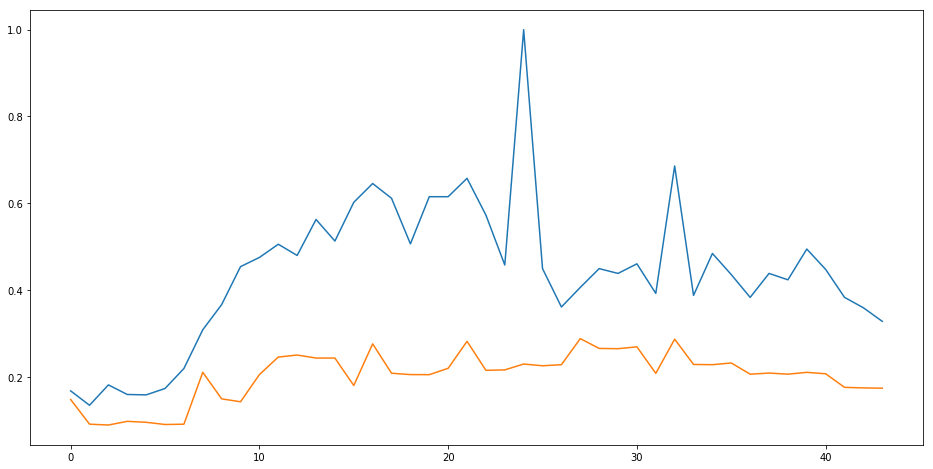

In [169]:
plt.figure(figsize=(16,8))
plt.plot(y_test)
plt.plot(yhat)
plt.show()